In [53]:
import pandas as pd
import scipy as sp
from scipy.stats import norm
import io
import requests
import numpy as np
import statsmodels.api as sm
from PyAstronomy import pyasl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (14.0, 10.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 500

In [189]:
csv = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'

content = requests.get(csv).content
df = pd.read_csv(io.StringIO(content.decode('utf-8')))

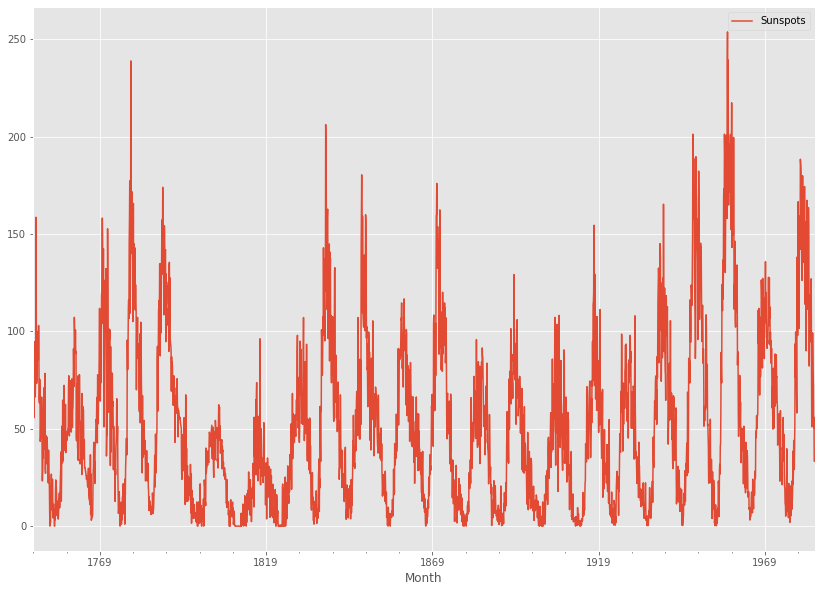

In [190]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True, drop=True)
fig = df.plot()

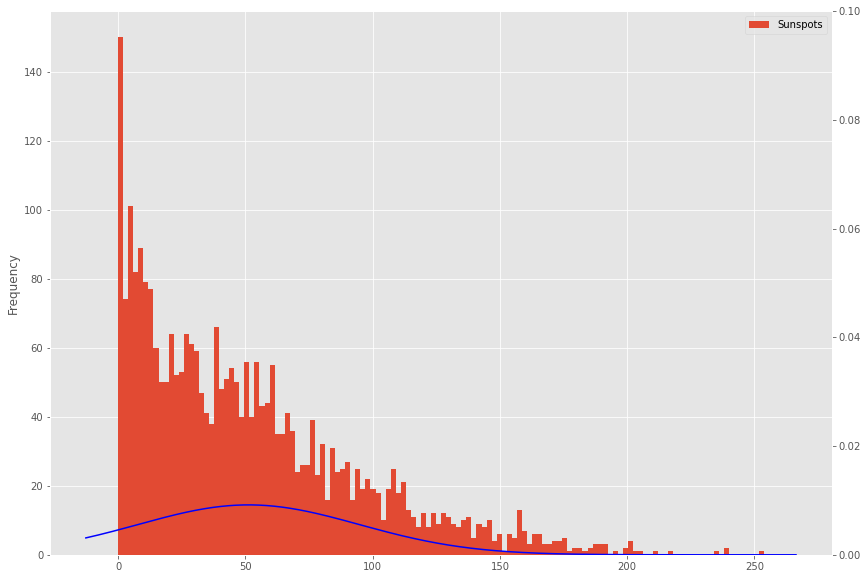

In [192]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
df.plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
ax2.set_ylim(0,0.1)
ax2.plot(x_axis, norm.pdf(x_axis,df.mean(),df.std()),color='blue')

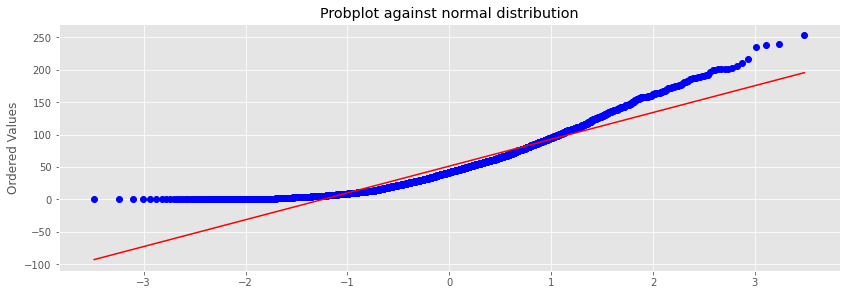

In [253]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
df['transform'] = df['Sunspots'] + 0.01 # does not work on 0s
prob = sp.stats.probplot(df['Sunspots'], dist=sp.stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

'''
# We can use a boxcox tranform so the data is closer to normal:
ax2 = fig.add_subplot(212)
df['transformed'], lmda = sp.stats.boxcox(df['transform'])
print(lmda)
prob = sp.stats.probplot(df['transformed'], dist=sp.stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
'''
plt.show()



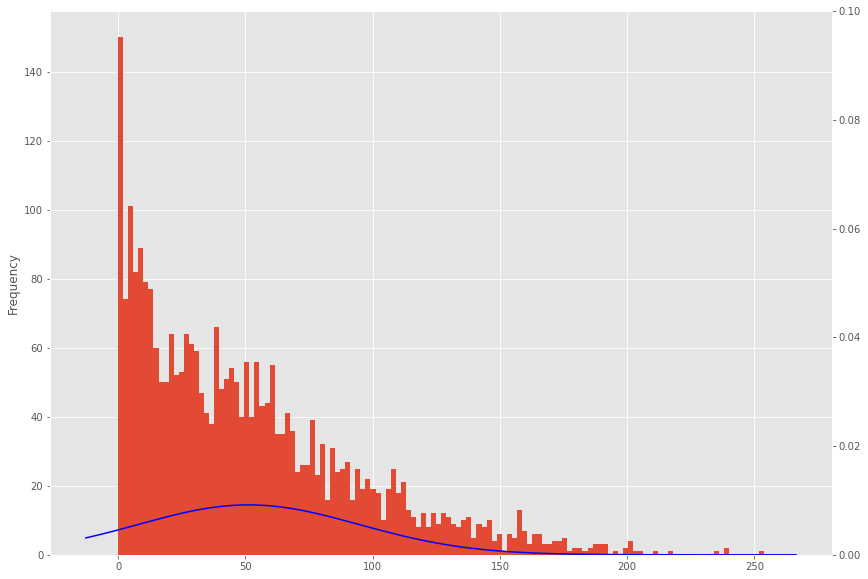

In [254]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
df['Sunspots'].plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
ax2.set_ylim(0,0.1)
ax2.plot(x_axis, norm.pdf(x_axis,df['Sunspots'].mean(),
                          df['Sunspots'].std()), color='blue')

We can see from the normal-qq plot and emperical pdf that the distribution is not normal.
However, it is important that the series given ESD is approximately normal.

## Seasonal decomposition

Split time series into its components, 
but first we have to handle noisy and missing data, here we:
*  Resample, aggregate the signal into fixed time buckets calculated using the mean
*  Intermolate filling any missing holes based on surronding data
For resampling I've kept it at its orignal monthly frequency.  For seasonality, it is important to have an understanding of the cyclical nature of your data.  For sunspots, the cycle is approximately every 11 years.

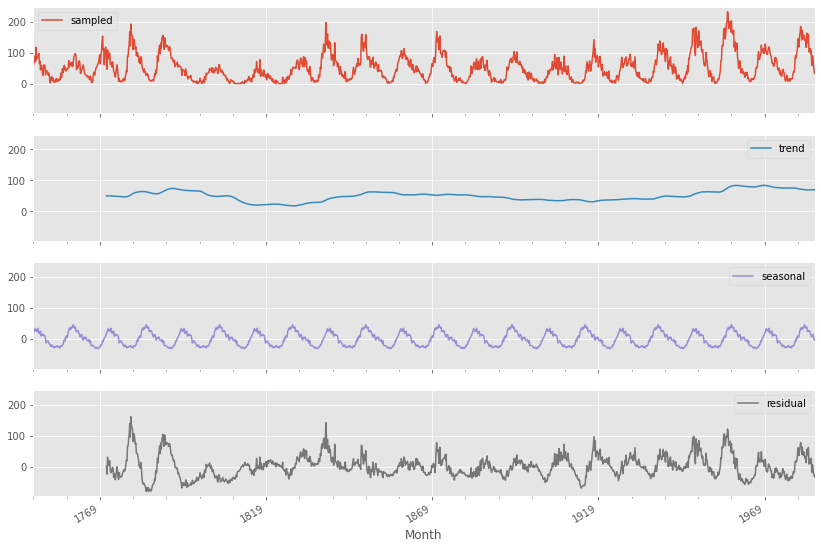

In [270]:
# time interval;
s_rule =  '2M' 

# numof of samples per trend period
n_sample = 12 * 11 # number observations per cycle  
#sf = df['transformed'].resample(s_rule).mean()
sf = df['Sunspots'].resample(s_rule).mean()
#sf.interpolate(method='time', inplace=True)
res = sm.tsa.seasonal_decompose(sf, 
                                model = 'additive', 
                                two_sided = False, 
                                period = n_sample)
rf = pd.concat([sf, res.trend, res.seasonal, res.resid], axis=1)
rf.columns = ['sampled', 'trend', 'seasonal', 'residual']
fig = rf.plot(subplots = True, sharey = True)



### Distribution of Residuals

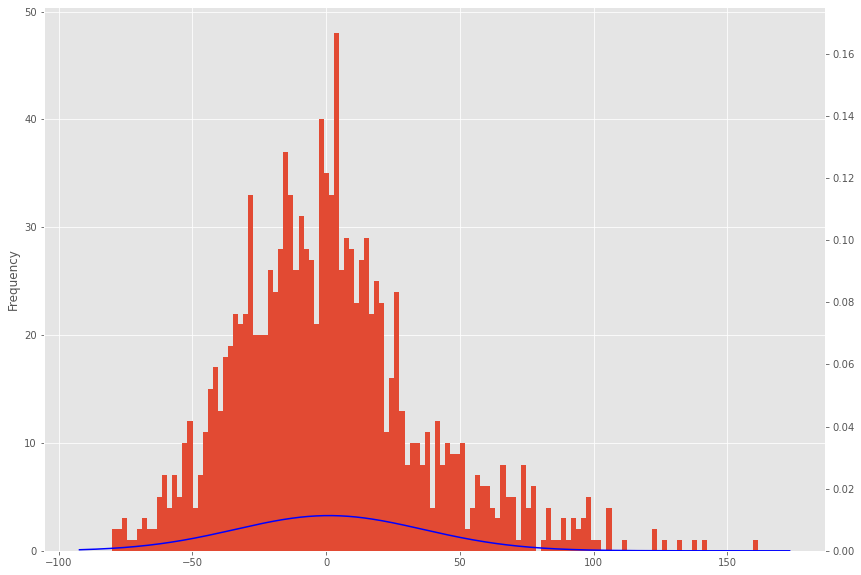

In [271]:
sf = res.resid
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
sf.plot.hist(stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax = plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
ax2.set_ylim(0,.175)
ax2.plot(x_axis, norm.pdf(x_axis,sf.mean(),sf.std()),color='blue')

### Use ESD to identify anomalies in residuals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff474b4e0d0>,
      dtype=object)

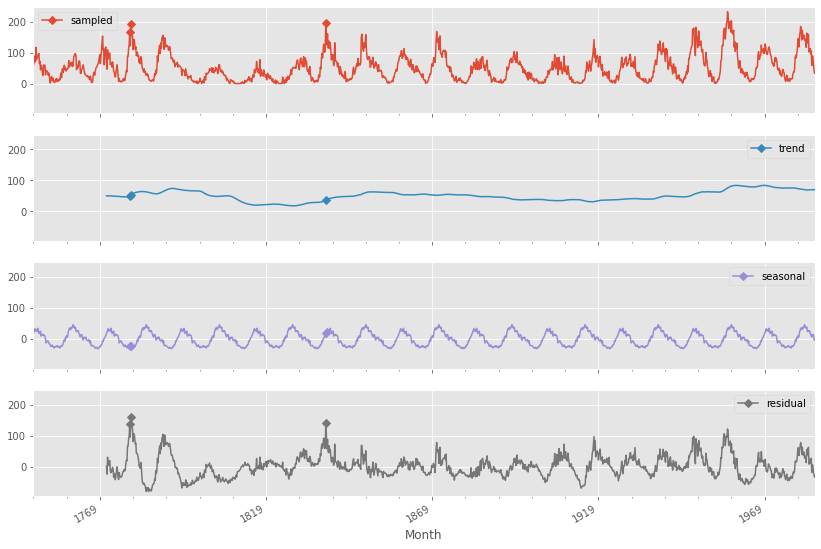

In [272]:
arr = rf['residual'][n_sample:]
nos, anomalies = pyasl.generalizedESD(arr, 
                                      maxOLs = 10, 
                                      alpha = 0.1, 
                                      fullOutput=False)
mark = [x+n_sample for x in anomalies]
rf.plot( subplots=True, sharey=True, marker='D', markevery=mark )